# Purpose of the Notebook

# Problem Statement

# Module Import

In [25]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import datetime
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

#to speed up pandas operands
from pandarallel import pandarallel

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import tensorflow.keras.utils as ku 


from project5_utils import my_print
from project5_utils import my_wait

from MyMovieReview import MovieReview
from MyMovieReview import MovieReviewGenerator

from mymovie import Movie

In [26]:
%matplotlib inline 

In [27]:
LOG_FILE = open("../Data/notebook.log","w")
DEBUG = 1

In [62]:
#Setting these for now will adjust them
VOCAB_SIZE = 10000
EMBEDDING_DIM = 32
MAX_LENGTH = 500
TRUC_TYPE = "post"
PAD_TYPE = "post"
#Out of Value Token -- or token to indicate a 
OOV_TOK = "<OOV>"

TRAIN_SET_PERCENT =  90.0
EPOCHS = 20
RANDOM_STATE = 42

BATCH_SIZE = 32

# Data Processing
Get reviews from PKL files into format that can be tokenized

In [29]:
MOVIE_REVIEWS_PKL_FILE = open("../Data/Reviews_back3.pkl","rb")

list_of_movie_reviews = []

while 1:
    try:
        temp_review = pickle.load(MOVIE_REVIEWS_PKL_FILE)
        list_of_movie_reviews.append(temp_review)
        my_print("added this review to the list ==>\n{}\n".format(temp_review), DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE reading movie reviews", DEBUG, LOG_FILE)
        break
        
MOVIE_REVIEWS_PKL_FILE.close()
print("Number of movie reviews read: {}".format(len(list_of_movie_reviews)))

Number of movie reviews read: 6449


In [30]:
col_names = list(list_of_movie_reviews[0].__dict__.keys())
#col_values = list(list_of_movie_reviews[0].__dict__.values()) --> TODO: REMOVE

In [31]:
list_of_movie_review_lists = []

for review_col_name in col_names:
    list_of_movie_review_data_vals = []
    
    for review_obj in list_of_movie_reviews:
        list_of_movie_review_data_vals.append ( review_obj.__dict__[review_col_name] )
        
    list_of_movie_review_lists.append(list_of_movie_review_data_vals)
    
reviews_dict = dict(zip(col_names,list_of_movie_review_lists))
reviews_df = pd.DataFrame(reviews_dict)
reviews_df.head()

,review_text,review_star_rating,reviewer_name,directlink_url,reviewlink_url,title,review_title,review_date
0,At the end of this movie there's a shot of the...,2,veardleyw,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4675276/,On the Basis of Sex,"Feeble, telemovie-style travesty of a potentia...",20 February 2019
1,The film starts in 1956 with RBG (Felicity Jon...,8,nogodnomasters,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4783407/,On the Basis of Sex,It's not a movement if everyone is just sitting.,15 April 2019
2,This well meaning movie shows the discriminati...,5,phd_travel,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4590175/,On the Basis of Sex,Well intentioned but miscast,18 January 2019
3,Why would you make a movie about the second fe...,1,Viking131313,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4621289/,On the Basis of Sex,Makes no sense.,2 February 2019
4,This movie was very well done. Good acting and...,10,MikeChm,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4583636/,On the Basis of Sex,Well worth going to see!,15 January 2019


**QUICK AND DIRTY CLEANING**

TODO: Go back and Improve it

In [32]:
#Get rid of instances of people spamming the same review
reviews_df.drop_duplicates(subset=["review_text"],keep="first",inplace=True)

In [33]:
#Get rid of reviews where "review_star_rating" is missing or "review_text" is missing
mask = (reviews_df["review_text"] == "EMPTY") | (reviews_df["review_star_rating"] == -1)
mask_keep = ~mask

In [34]:
reviews_df = reviews_df[mask_keep]

In [35]:
reviews_df.dropna(inplace=True)

In [36]:
reviews_df.shape

(6443, 8)

In [37]:
text_of_reviews = reviews_df[["review_text","review_star_rating"]]

In [38]:
text_of_reviews.head()

,review_text,review_star_rating
0,At the end of this movie there's a shot of the...,2
1,The film starts in 1956 with RBG (Felicity Jon...,8
2,This well meaning movie shows the discriminati...,5
3,Why would you make a movie about the second fe...,1
4,This movie was very well done. Good acting and...,10


In [39]:
len(text_of_reviews)

6443

In [40]:
text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())

<ipython-input-40-6d6c3b513ca5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())


In [41]:
text_of_reviews.head()

,review_text,review_star_rating
0,at the end of this movie there's a shot of the...,2
1,the film starts in 1956 with rbg (felicity jon...,8
2,this well meaning movie shows the discriminati...,5
3,why would you make a movie about the second fe...,1
4,this movie was very well done. good acting and...,10


In [42]:
#shifting range of ratings from 1,10 to 0,9
text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1

<ipython-input-42-fd720e7df4eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1


In [43]:
text_of_reviews.shape

(6443, 2)

In [44]:
#TODO Randomize sets or find tensorflow train test split or use sklearn train test split
train_set_size = int ( ( text_of_reviews.shape[0] * TRAIN_SET_PERCENT ) / 100 )
#test_set_size =  text_of_reviews.shape[0] - train_set_size

review_indices = np.arange(text_of_reviews.shape[0]) 

np.random.shuffle( review_indices)


text_of_reviews = text_of_reviews.iloc[review_indices]

training_indices = review_indices[:train_set_size]
testing_indices = review_indices[train_set_size:]


print(train_set_size)
print(text_of_reviews.shape)
print(training_indices.shape)
print(testing_indices.shape)


5798
(6443, 2)
(5798,)
(645,)


In [45]:
text_of_reviews.head()

,review_text,review_star_rating
1509,good time is a small movie about small people ...,7
899,modern exploitation guru quentin tarantino ser...,5
4572,james mcavoy has acted excellently in this fil...,9
3206,"a quick "" dvd-review "" .henry cavill ⭐ carries...",9
283,usually i try to be careful with over hyping a...,9


In [46]:
#spent hours trying to re-implement train_test_split() :*-(

#train_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_text"]
#train_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_star_rating"]

#train_text_reviews = text_of_reviews.sample(n=train_set_size, random_state=RANDOM_STATE, )

#test_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_text"]
#test_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_star_rating"]

X = text_of_reviews["review_text"]
y = text_of_reviews["review_star_rating"]

Test_Size = 1.0 - (TRAIN_SET_PERCENT/100.0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Test_Size, random_state=RANDOM_STATE)


In [47]:
#TODO
#Lemmatization
#stop word removal
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5798,)
(5798,)
(645,)
(645,)


In [48]:
tokenizer = Tokenizer(oov_token=OOV_TOK, num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
total_words = len(tokenizer.word_index)+1
i = 0
for key, value in tokenizer.word_index.items():
    
    if i == 10:
        break
        
    print("word_index[{}] = {}".format(key, value))
    i += 1
    
print("\ntotal words is {}".format(total_words))

word_index[<OOV>] = 1
word_index[the] = 2
word_index[and] = 3
word_index[a] = 4
word_index[of] = 5
word_index[to] = 6
word_index[is] = 7
word_index[in] = 8
word_index[it] = 9
word_index[i] = 10

total words is 39197


In [49]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [50]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [51]:
for i, thing in enumerate(X_train_seq):
    if i == 3:
        break
    print("thing = {}".format(thing))

thing = [103, 166, 2, 508, 10, 13, 61, 2892, 39, 2, 14, 83, 5, 87, 813, 3, 944, 6, 24, 4, 61, 51, 14, 18, 22, 2, 92, 435, 10, 600, 75, 125, 2, 84, 944, 51, 95, 8, 2, 379, 897, 58, 10, 13, 1756, 11, 31, 4577, 9, 58, 3, 189, 153, 170, 4816, 40, 1, 15, 72, 330, 277, 3, 125, 45, 3, 52, 146, 45, 3, 40, 73, 29, 10, 497, 56, 1804, 3, 306, 8, 2, 14, 15, 1705, 1317, 18, 102, 184, 34, 2, 450, 10, 600, 12, 14, 68, 24, 370, 2, 80, 260, 61, 3556, 55, 3, 10, 290, 485, 8, 4, 219, 809, 15, 245, 94, 3, 1135, 14, 21, 74, 2, 423, 35, 21, 67, 2346, 8, 9, 3, 21, 61, 145, 15, 432, 1229, 34, 2, 450, 6, 2, 118, 10, 91, 35, 432, 1229, 8, 882, 18, 12, 212, 36, 1862, 90, 1300, 44, 1467, 12, 14, 101, 4295, 12, 34, 806, 6, 806, 10, 13, 46, 3, 46, 8, 12, 370, 45, 3, 347, 6, 203, 1648, 18, 959, 2, 14, 897, 3, 10, 13, 61, 2795, 15, 181, 122, 235, 73, 44, 300, 505, 4, 1296, 45, 66, 494, 3, 61, 598, 3, 51, 323, 94, 107, 9, 16, 55, 2, 96, 14, 10, 378, 8, 4, 121, 3, 10, 110, 224, 72, 95, 60, 175, 10, 91, 35, 6, 446, 95, 

In [52]:
print(X_train_seq_pad.shape)

(5798, 500)


In [53]:
#Convert to numpy arrays to work with Tensorflow
X_train_seq_pad = np.array(X_train_seq_pad)
y_train = np.array(y_train)

X_test_seq_pad = np.array(X_test_seq_pad)
y_test = np.array(y_test)



In [54]:
X_train_seq_pad.shape, y_train.shape

((5798, 500), (5798,))

In [55]:
X_test_seq_pad.shape, y_test.shape

((645, 500), (645,))

In [56]:
X_test_seq_pad[:3]

array([[  10, 1125,  197, ...,    1,  972,  757],
       [  80,  328,   55, ...,    6,    2,  198],
       [  38,   30,    5, ...,    0,    0,    0]], dtype=int32)

In [57]:
y_train[:3]

array([8, 9, 7])

# Baseline Model

In [58]:
#baseline_model = Sequential([
#    Embedding(VOCAB_SIZE + 1,EMBEDDING_DIM, input_length=MAX_LENGTH),
#    GlobalAveragePooling1D(),
#    Dense(500, activation="relu"),
#    Dense(250, activation="relu"),
#    Dense(125, activation="relu"),
#    Dense(60, activation="relu"),
#    Dense(30, activation="relu"),
#    Dense(15, activation="relu"),
#    Dense(10, activation="softmax")
#])

baseline_model = Sequential()
baseline_model.add(Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAX_LENGTH))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(MaxPooling1D(5))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(GlobalMaxPooling1D())
baseline_model.add(Dense(15, activation="relu"))
baseline_model.add(Dense(10, activation="softmax"))

baseline_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320032    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 15)                495       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [60]:
training_history = baseline_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE, 
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/20
164/164 [==============================] - 2s 13ms/step - loss: 2.2439 - acc: 0.1401 - val_loss: 2.1976 - val_acc: 0.1776
Epoch 2/20
164/164 [==============================] - 2s 12ms/step - loss: 2.1656 - acc: 0.1949 - val_loss: 2.1659 - val_acc: 0.1776
Epoch 3/20
164/164 [==============================] - 2s 12ms/step - loss: 2.0124 - acc: 0.2754 - val_loss: 1.8815 - val_acc: 0.3052
Epoch 4/20
164/164 [==============================] - 2s 11ms/step - loss: 1.7151 - acc: 0.3532 - val_loss: 1.8045 - val_acc: 0.3172
Epoch 5/20
164/164 [==============================] - 2s 12ms/step - loss: 1.5007 - acc: 0.4044 - val_loss: 1.8065 - val_acc: 0.3121
Epoch 6/20
164/164 [==============================] - 2s 11ms/step - loss: 1.2803 - acc: 0.5019 - val_loss: 1.9494 - val_acc: 0.3000
Epoch 7/20
164/164 [==============================] - 2s 11ms/step - loss: 1.0397 - acc: 0.6198 - val_loss: 2.2597 - val_acc: 0.2724
Epoch 8/20
164/164 [==============================] - 2s 12ms/step - 

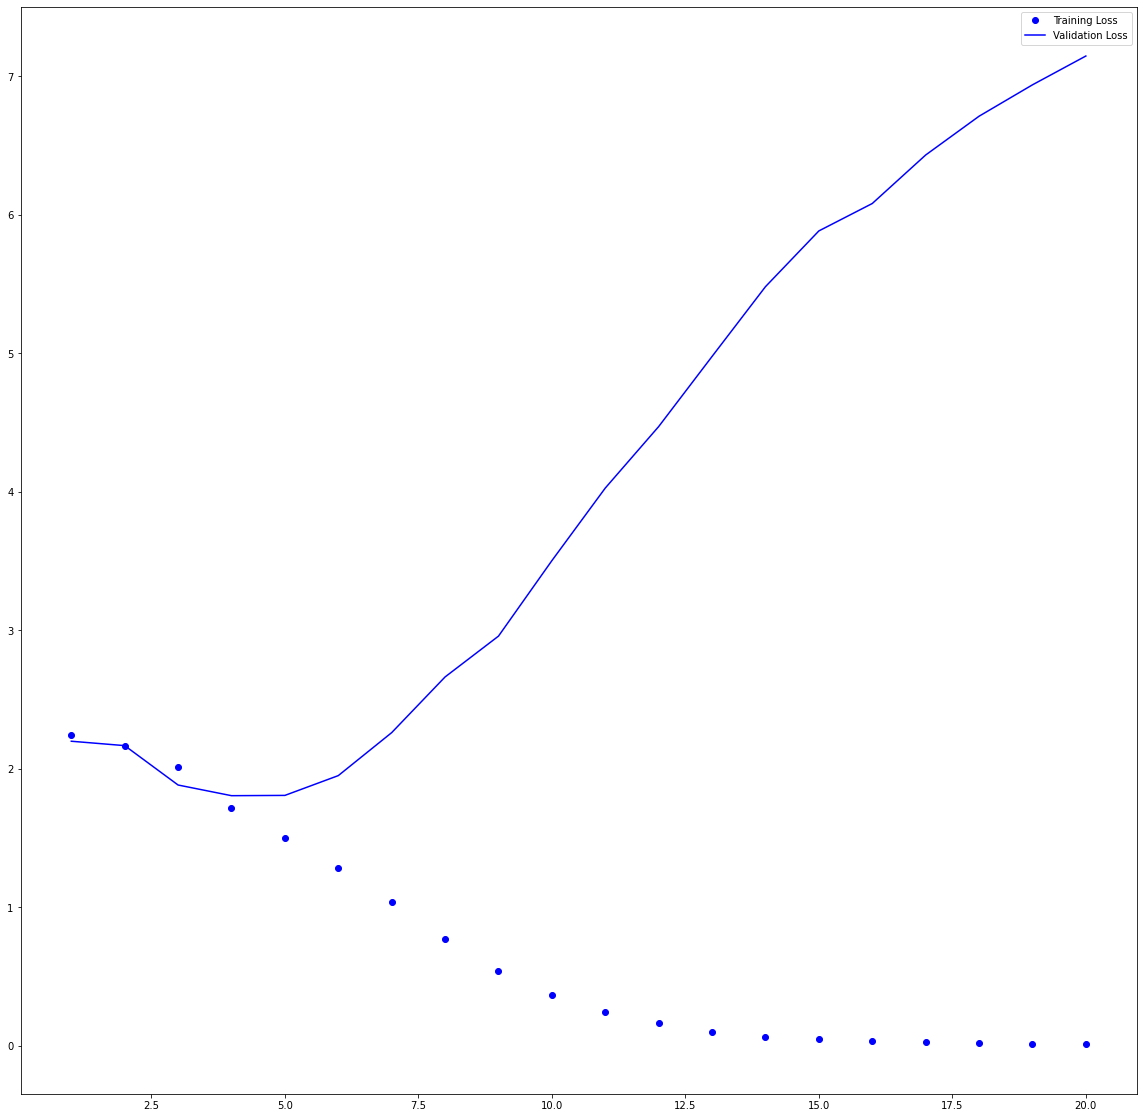

In [61]:
loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")
plt.legend()
plt.show()

Huge overfit (Uuuge!)

## Test Example

In [64]:
score, acc = baseline_model.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

21/21 [==============================] - 0s 3ms/step - loss: 7.4537 - acc: 0.2419


In [65]:
print(score)

7.45366096496582


In [66]:
print(acc)

0.24186046421527863


# Updated Model

# Conclusion